# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import os
import quandl
import inflection
import warnings
import bisect
import pandas as pd
import numpy as np
import scipy.stats  as ss

from IPython.display         import Image
from IPython.core.display    import HTML

import matplotlib.pyplot as plt
import seaborn as sns

# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

### 0.1.1 Notebook Config

In [2]:
def jupyter_settings(seed):
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
seed = 42

jupyter_settings(seed)

Populating the interactive namespace from numpy and matplotlib


C:\Users\fabio\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Helper Functions

In [107]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



def group_age(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def cramerV(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## 0.3 Load Data

In [7]:
df_raw = pd.read_csv('../../01-Data/churn.csv')

In [8]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
country_indicators = {
                        'BCA': 'current_account_balance',
                        'LE':'employment',
                        'NGDP_D': 'GDP_deflator',
                        'GGXWDG': 'general_government_gross_debt',
                        'GGR': 'general_government_revenue',
                        'GGSB': 'general_government_structural_balance',
                        'PCPI': 'inflation_index_average_consumer_prices',
                        'PPPPC': 'per_capita_GDP_PPP_valuation'
                    }

countries = {
           'FRA': 'France',
           'DEU':'Germany',
           'ESP': 'Spain'
        }
#https://www.quandl.com/data/ODA-IMF-Cross-Country-Macroeconomic-Statistics/documentation
#https://s3.amazonaws.com/quandl-production-static/API+Descriptions/WHO/ccodes.txt
data_dict ={
                'current_account_balance': [],
                'employment': [],
                'GDP_deflator': [],
                'general_government_gross_debt': [],
                'general_government_revenue': [],
                'general_government_structural_balance': [],
                'inflation_index_average_consumer_prices': [],
                'per_capita_GDP_PPP_valuation': [],
                'Geography':[]
            }

quandl_api_key = os.environ.get('QUANDL_API_KEY')
quandl.ApiConfig.api_key = quandl_api_key

for country in countries.keys():
    for ind in country_indicators.keys():
        data = quandl.get("ODA/{}_{}".format(country, ind), start_date='2020-12-31', end_date='2020-12-31')
        data_dict[country_indicators[ind]].append(data.iloc[0,0])
    data_dict['Geography'].append(countries[country])
df_country_indicators = pd.DataFrame(data_dict)    
df_country_indicators.head()

,current_account_balance,employment,GDP_deflator,general_government_gross_debt,general_government_revenue,general_government_structural_balance,inflation_index_average_consumer_prices,per_capita_GDP_PPP_valuation,Geography
0,-0.546,25.736,106.191,2455.29,1293.890,-61.129,106.598,48415.25,France
1,282.002,42.031,118.398,1935.55,1629.620,22.988,107.193,55764.47,Germany
2,12.455,19.763,106.502,1229.61,501.761,-35.873,106.625,43006.94,Spain


In [12]:
df_raw_new = pd.merge(df_raw, df_country_indicators, how='left', on='Geography')
df_raw_new.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,current_account_balance,employment,GDP_deflator,general_government_gross_debt,general_government_revenue,general_government_structural_balance,inflation_index_average_consumer_prices,per_capita_GDP_PPP_valuation
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,-0.546,25.736,106.191,2455.29,1293.890,-61.129,106.598,48415.25
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,12.455,19.763,106.502,1229.61,501.761,-35.873,106.625,43006.94
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,-0.546,25.736,106.191,2455.29,1293.890,-61.129,106.598,48415.25
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,-0.546,25.736,106.191,2455.29,1293.890,-61.129,106.598,48415.25
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,12.455,19.763,106.502,1229.61,501.761,-35.873,106.625,43006.94


### 0.3.1 Split data into train and test dataset

In [13]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw_new, df_raw_new['Exited']):
    train_dataset = df_raw_new.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw_new.loc[test_index].reset_index(drop=True)

### 0.3.2 Saving Train and Test Dataset

In [14]:
# Convert to .Feather Data
train_dataset.to_feather('00-Data/train_dataset.feather')
test_dataset.to_feather('00-Data/test_dataset.feather')

### 0.3.3 Load Train Dataset

In [15]:
df_train_dataset = pd.read_feather('00-Data/train_dataset.feather')

# 1.0 DATA DESCRIPTION

In [16]:
df01 = df_train_dataset.copy()

# 1.1 Data Information
---

> - **RowNumber:**       Corresponds to the record (row) number;
> - **CustomerId:**      Contains unique identifier;
> - **Surname:**         Customer's surname;
> - **CreditScore:**     Customer's credit score for the consumer market;
> - **Geography:**       Customer’s country;
> - **Gender:**          Customer's gender;
> - **Age:**             Customer's age;
> - **Tenure:**          Number of years that the customer has been a client of the bank;
> - **Balance:**         The amount that the customer has in the bank account;
> - **NumOfProducts:**   Refers to the number of products that a customer has purchased through the bank;
> - **HasCrCard:**       Denotes whether or not a customer has a credit card;
> - **IsActiveMember:**  Denotes whether or not a customer is an active member;
> - **EstimatedSalary:** Estimate customer's annually income;
> - **Exited:**          Whether or not the customer is in Churn;

> - **current_account_balance:** Current Account Balance, USD Billions 
> - **employment:** Employment, Millions
> - **GDP_deflator:** GDP Deflator
> - **general_government_gross_debt:** General Government Gross Debt, USD Billions
> - **general_government_revenue:** General Government Revenue, USD Billions
> - **general_government_structural_balance:** General Government Structural Balance, USD Billions
> - **inflation_index_average_consumer_prices:** Inflation Index, Average Consumer Prices
> - **per_capita_GDP_PPP_valuation:** Per Capita GDP based on PPP Valuation, USD

## 1.2 Columns

In [17]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited',
       'current_account_balance', 'employment', 'GDP_deflator',
       'general_government_gross_debt', 'general_government_revenue',
       'general_government_structural_balance',
       'inflation_index_average_consumer_prices',
       'per_capita_GDP_PPP_valuation'],
      dtype='object')

### 1.2.1 Rename Columns

In [18]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

#### 1.2.2 New Name Columns

In [19]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited',
       'current_account_balance', 'employment', 'gdp_deflator',
       'general_government_gross_debt', 'general_government_revenue',
       'general_government_structural_balance',
       'inflation_index_average_consumer_prices',
       'per_capita_gdp_ppp_valuation'],
      dtype='object')

## 1.3 Data Dimensions

In [20]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 8000
Number of Columns: 22


## 1.4 Data Types

In [21]:
df01.dtypes

row_number                                   int64
customer_id                                  int64
surname                                     object
credit_score                                 int64
geography                                   object
gender                                      object
age                                          int64
tenure                                       int64
balance                                    float64
num_of_products                              int64
has_cr_card                                  int64
is_active_member                             int64
estimated_salary                           float64
exited                                       int64
current_account_balance                    float64
employment                                 float64
gdp_deflator                               float64
general_government_gross_debt              float64
general_government_revenue                 float64
general_government_structural_b

## 1.5 Not a Number

### 1.5.1 Sum NA

In [22]:
df01.isnull().sum()

row_number                                 0
customer_id                                0
surname                                    0
credit_score                               0
geography                                  0
gender                                     0
age                                        0
tenure                                     0
balance                                    0
num_of_products                            0
has_cr_card                                0
is_active_member                           0
estimated_salary                           0
exited                                     0
current_account_balance                    0
employment                                 0
gdp_deflator                               0
general_government_gross_debt              0
general_government_revenue                 0
general_government_structural_balance      0
inflation_index_average_consumer_prices    0
per_capita_gdp_ppp_valuation               0
dtype: int

### 1.5.2 ~~Fillout NA~~

there is no NA values

## 1.6 Descriptive Statistical

In [23]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
not_numerial = ['row_number', 'customer_id']
num_attributes_cols = list(np.setdiff1d(num_attributes.columns, not_numerial))
num_attributes = num_attributes[num_attributes_cols]

#Categorical Attributes
cat_attributes = df01.select_dtypes(include=['object'])

### 1.5.1 Numerical Attributes

In [24]:
## Statatistical Summary (Helper Function)
statistical_summary(num_attributes)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,18.00,92.00,74.00,35.00,38.946625,37.000,25.0000,27.000,32.0000,44.000,53.000,60.000,10.526219,0.270273,1.035706,1.459448
1,balance,0.00,238387.56,238387.56,0.00,76381.207499,97055.145,0.0000,0.000,0.0000,127633.195,149005.811,162442.667,62298.159597,0.815622,-0.141721,-1.492209
2,credit_score,350.00,850.00,500.00,850.00,650.752500,652.000,489.0000,522.000,584.0000,717.000,778.000,812.000,96.590394,0.148429,-0.079540,-0.418624
3,current_account_balance,-0.55,282.00,282.55,-0.55,73.519846,12.460,-0.5500,-0.550,-0.5500,282.000,282.000,282.000,120.683625,1.641511,1.144441,-0.680475
4,employment,19.76,42.03,22.27,25.74,28.326186,25.740,19.7600,19.760,19.7600,42.030,42.030,42.030,8.292621,0.292755,0.840203,-0.841053
5,estimated_salary,11.58,199992.48,199980.90,24924.92,99730.811581,99446.940,9903.3685,20330.208,50691.8175,148527.730,179035.035,190113.789,57331.532983,0.574863,0.007126,-1.174789
6,exited,0.00,1.00,1.00,0.00,0.203750,0.000,0.0000,0.000,0.0000,0.000,1.000,1.000,0.402785,1.976860,1.471283,0.164715
7,gdp_deflator,106.19,118.40,12.21,106.19,109.327709,106.500,106.1900,106.190,106.1900,118.400,118.400,118.400,5.248146,0.048004,1.149071,-0.676765
8,general_government_gross_debt,1229.61,2455.29,1225.68,2455.29,2018.303742,1935.550,1229.6100,1229.610,1229.6100,2455.290,2455.290,2455.290,502.685485,0.249063,-0.639870,-1.198352
9,general_government_revenue,501.76,1629.62,1127.86,1293.89,1179.801799,1293.890,501.7600,501.760,501.7600,1629.620,1629.620,1629.620,415.038961,0.351787,-0.761849,-0.868588


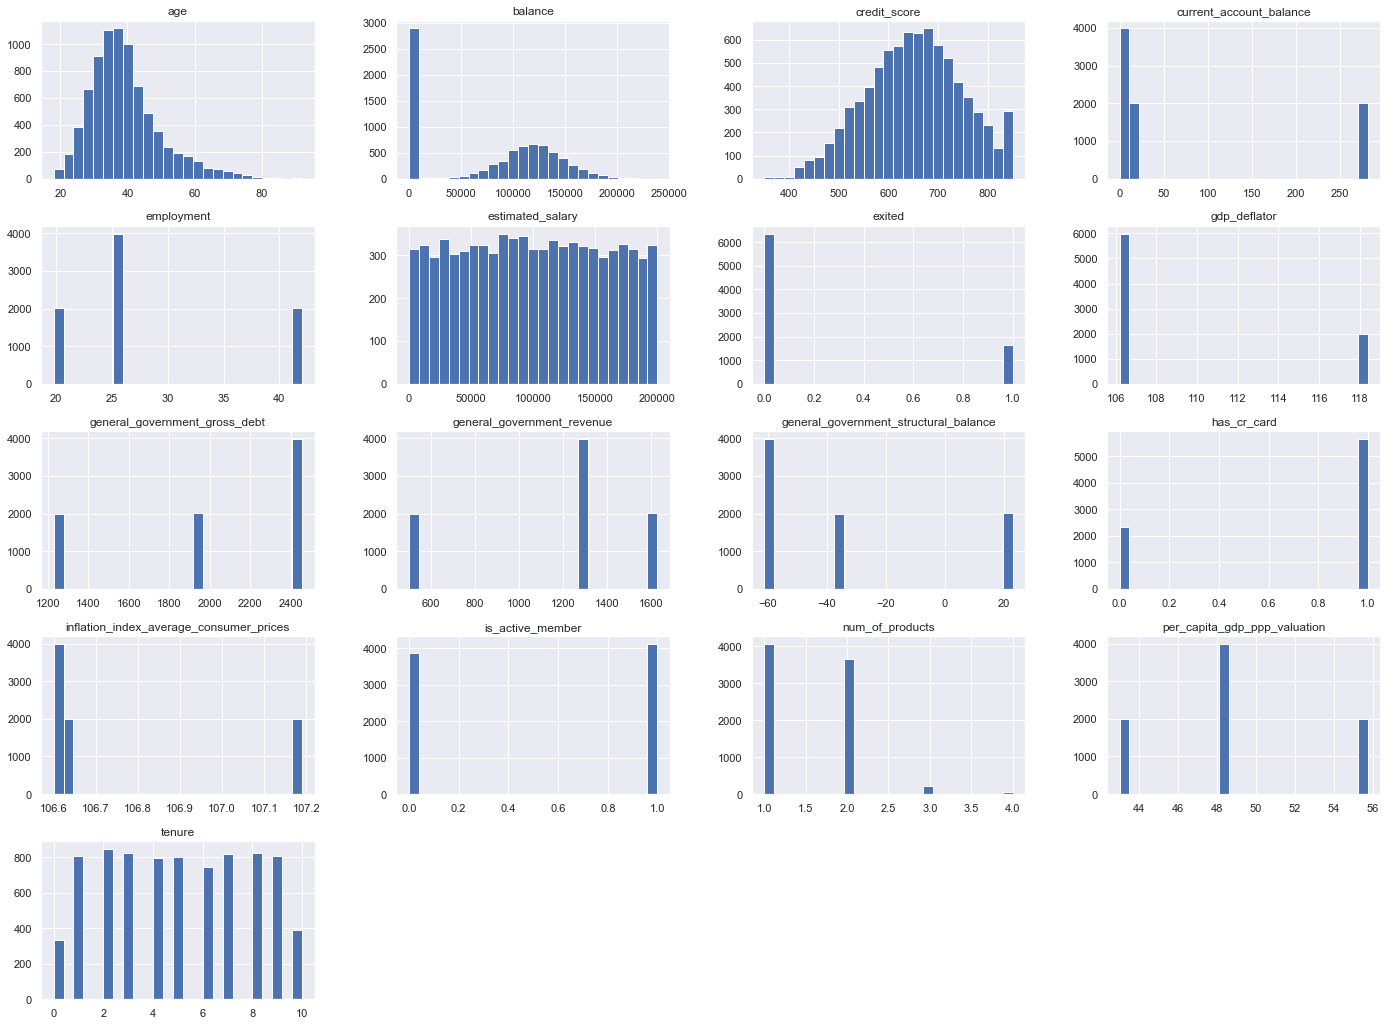

In [25]:
num_attributes.hist(bins=25, figsize=(24,18));

#### 1.5.1.2 Some considerations
---
> **age**
>> - The age range is large and it will be interesting to group by bands
>> - 50% are between 32 and 44 years (Adults)
>
> **balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - Almost 38% equals 0.00
>
> **credit_score**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **estimated_salary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a uniform distribution with great dispersion
>
> **has_cr_card**
>> - 75% has credit card
>
> **is_active_member**
>> - 50% of the customers has done a bank activity in the past 12 months
>
> **num_of_products**
>> - all customers have bought at least one product
>
> **tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>

>
> **exited**
>> - Customers in Churn: 20% (Disbalanced Dataset) 

## 2.0 FEATURE ENGINEERING

In [26]:
df02 = df01.copy()

## 2.1 Mind Map

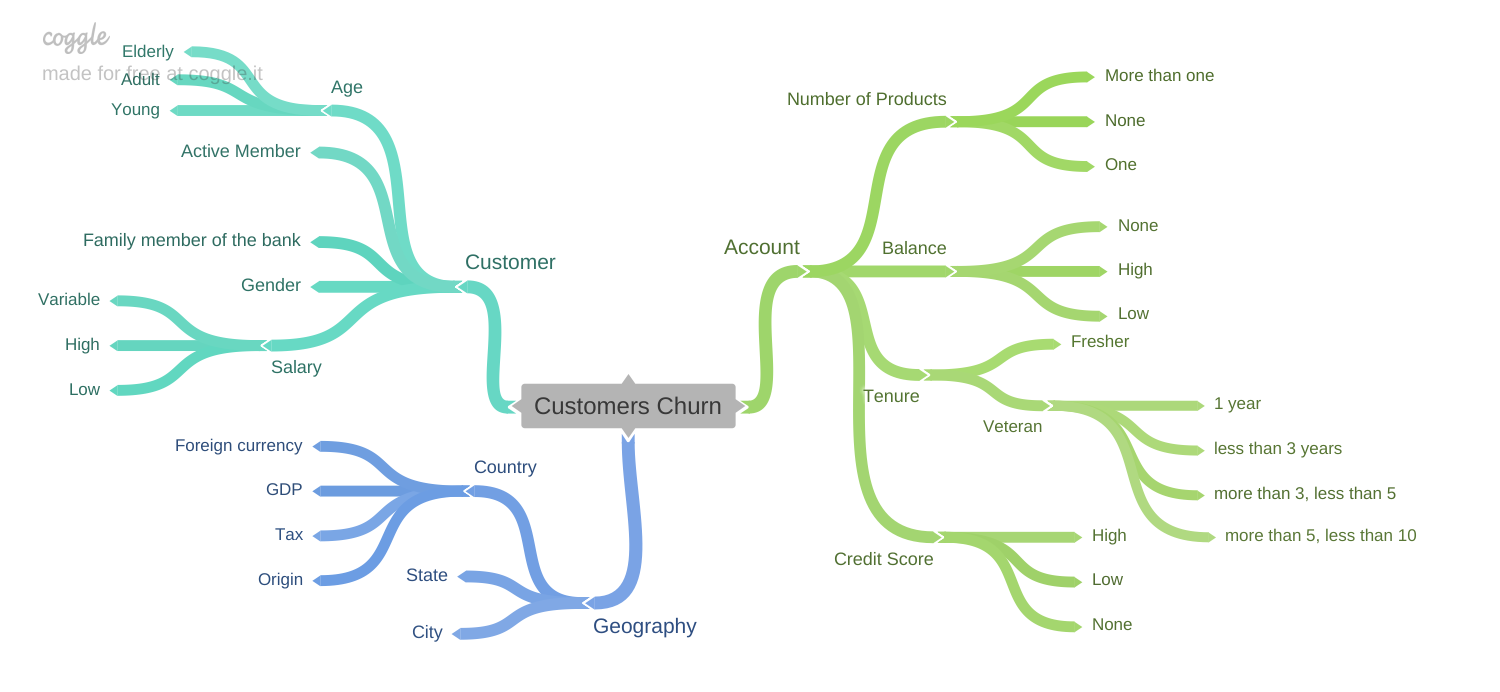

In [27]:
Image('../../img/01-FirstCycleCRISPCostumerChurn.png')

### 2.1.1 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Customers with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Churn should occur for customers with high salary
>> - H07 - Churn should occur for customers with high balance
>
> **Geography**
>> - H01 - Countries with higher GDP should have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin should have higher number of churn
>
> **Account**
>> - H01 - Active members should have less churn
>> - H02 - Active members should have more products
>> - H03 - The more products the customer has, the less likely it is to go into churn
>> - H04 - Customers with credit cards are more active
>> - H05 - Churn should occur for customers with low tenur
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

### 2.1.2 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

## 2.2 Feature Engineering

In [28]:
# Tenure Vigency
df02['tenure_vigency'] = df02['tenure'] + 1

# tenure_vigency / age
df02['tenure_vigency_age'] = df02['tenure_vigency'] / df02['age']

# credit_score / tenure_vigency
df02['cred_score_tenure_vigency'] = df02['credit_score'] / df02['tenure_vigency']

# credit_score / age
df02['cred_age'] = df02['credit_score'] / df02['age']

# amount
df02['amount'] = df02['estimated_salary'] + df02['balance']

# amount / credit_score
df02['amount_credit'] = df02['amount'] / df02['credit_score']

# amount / tenure_vigency
df02['amount_tenure_vigency'] = df02['amount'] / df02['tenure_vigency']

# amount / num_of_products
df02['amount_num_of_products'] = df02['amount'] / df02['num_of_products']

# credit score / num_of_products
df02['cred_num_of_products'] = df02['credit_score'] / df02['num_of_products']

# balance / tenure_vigency
df02['bal_tenure_vigency'] = df02['balance'] / df02['tenure_vigency']

# num_of_products - credit card
df02['num_of_products_has_cr_card_sub'] = df02['num_of_products'] - df02['has_cr_card']

# num_of_products * credit card
df02['num_of_products_has_cr_card_mul'] = df02['num_of_products'] * df02['has_cr_card']

# tenure_vigency_age * balance
df02['tenure_vigency_age_balance'] = df02['tenure_vigency_age'] * df02['balance']

# balance * is_active_member
df02['balance_is_active_member'] = df02['balance'] * df02['is_active_member']

# Group Age
df02['age_group'] = df02['age'].apply(lambda row: group_age(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)

# balance / current_account_balance
df02['balance_current_account_balance'] = df02['balance'] / df02['current_account_balance']

# credit_score / inflation_index_average_consumer_prices
df02['credit_score_inflation_index'] = df02['credit_score'] / df02['inflation_index_average_consumer_prices']

# num_of_products / inflation_index_average_consumer_prices
df02['num_of_products_inflation_index'] = df02['num_of_products'] / df02['inflation_index_average_consumer_prices']

# credit_score / per_capita_gdp_ppp_valuation
df02['credit_score_per_capita_gdp_ppp_valuation'] = df02['credit_score'] / df02['per_capita_gdp_ppp_valuation']

# tenure * (per_capita_gdp_ppp_valuation / employment)
df02['tenure_employment_per_capita_gdp_ppp_valuation'] = (df02['per_capita_gdp_ppp_valuation'] / df02['employment']) * df02['tenure']

# estimated_salary / per_capita_gdp_ppp_valuation
df02['estimated_salary_per_capita_gdp_ppp_valuation'] = df02['estimated_salary'] / df02['per_capita_gdp_ppp_valuation']

# (estimated_salary * per_capita_gdp_ppp_valuation) / credit_score
df02['estimated_salary_inflation_index_credit_score'] = (df02['estimated_salary'] * df02['per_capita_gdp_ppp_valuation']) / df02['credit_score']

# num_of_products / gdp_deflator
df02['num_of_products_gdp_deflator'] = df02['num_of_products'] / df02['gdp_deflator']

# (tenure * credit_score) / employment
df02['tenure_credit_score_employment'] = (df02['tenure'] * df02['credit_score']) / df02['employment']

# (general_government_gross_debt / general_government_revenue) * estimated_salary
df02['num_of_products_gdp_deflator'] = (df02['general_government_gross_debt'] / df02['general_government_revenue']) * df02['estimated_salary']

# 3.0. VARIABLES FILTERING

In [29]:
df03 = df02.copy()

## 3.1 ~~Row Fitering~~

## 3.2 Columns Filtering

In [30]:
to_drop = ['row_number', 'customer_id', 'surname']
df03.drop(to_drop, axis=1, inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [31]:
df04 = df03.copy()

## 4.1 Response Variable

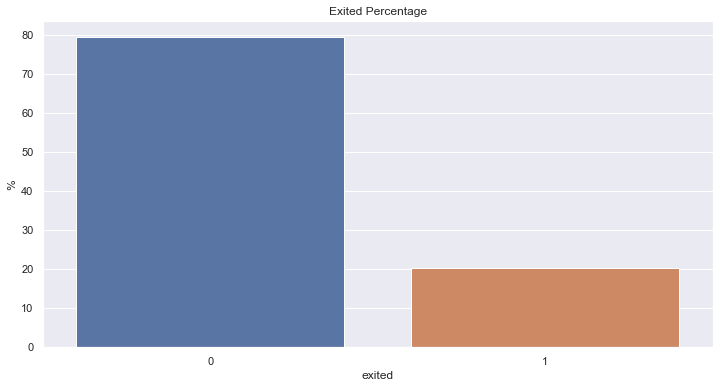

In [32]:
exited_percentage = df04['exited'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=exited_percentage.index, y=exited_percentage);
plt.ylabel('%');
plt.xlabel('exited');
plt.title('Exited Percentage');

## 4.2 Univariate Analysis

### 4.2.1 Numerical Attributes

In [33]:
num_attributes = df04.select_dtypes(include=['int64', 'float64'])
statistical_summary(num_attributes)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,credit_score,350.000000,850.000000,500.000000,850.000000,650.752500,652.000000,489.000000,522.000000,584.000000,717.000000,778.000000,812.000000,96.590394,0.148429,-0.079540,-0.418624
1,age,18.000000,92.000000,74.000000,35.000000,38.946625,37.000000,25.000000,27.000000,32.000000,44.000000,53.000000,60.000000,10.526219,0.270273,1.035706,1.459448
2,tenure,0.000000,10.000000,10.000000,2.000000,5.016625,5.000000,1.000000,1.000000,3.000000,8.000000,9.000000,9.000000,2.896610,0.577402,0.013124,-1.172842
3,balance,0.000000,238387.560000,238387.560000,0.000000,76381.207499,97055.145000,0.000000,0.000000,0.000000,127633.195000,149005.811000,162442.667000,62298.159597,0.815622,-0.141721,-1.492209
4,num_of_products,1.000000,4.000000,3.000000,1.000000,1.529500,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.581704,0.380323,0.755984,0.636943
5,has_cr_card,0.000000,1.000000,1.000000,1.000000,0.708750,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.454338,0.641042,-0.919091,-1.155561
6,is_active_member,0.000000,1.000000,1.000000,1.000000,0.514875,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.499779,0.970680,-0.059538,-1.996955
7,estimated_salary,11.580000,199992.480000,199980.900000,24924.920000,99730.811581,99446.940000,9903.368500,20330.208000,50691.817500,148527.730000,179035.035000,190113.789000,57331.532983,0.574863,0.007126,-1.174789
8,exited,0.000000,1.000000,1.000000,0.000000,0.203750,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.402785,1.976860,1.471283,0.164715
9,current_account_balance,-0.550000,282.000000,282.550000,-0.550000,73.519846,12.460000,-0.550000,-0.550000,-0.550000,282.000000,282.000000,282.000000,120.683625,1.641511,1.144441,-0.680475


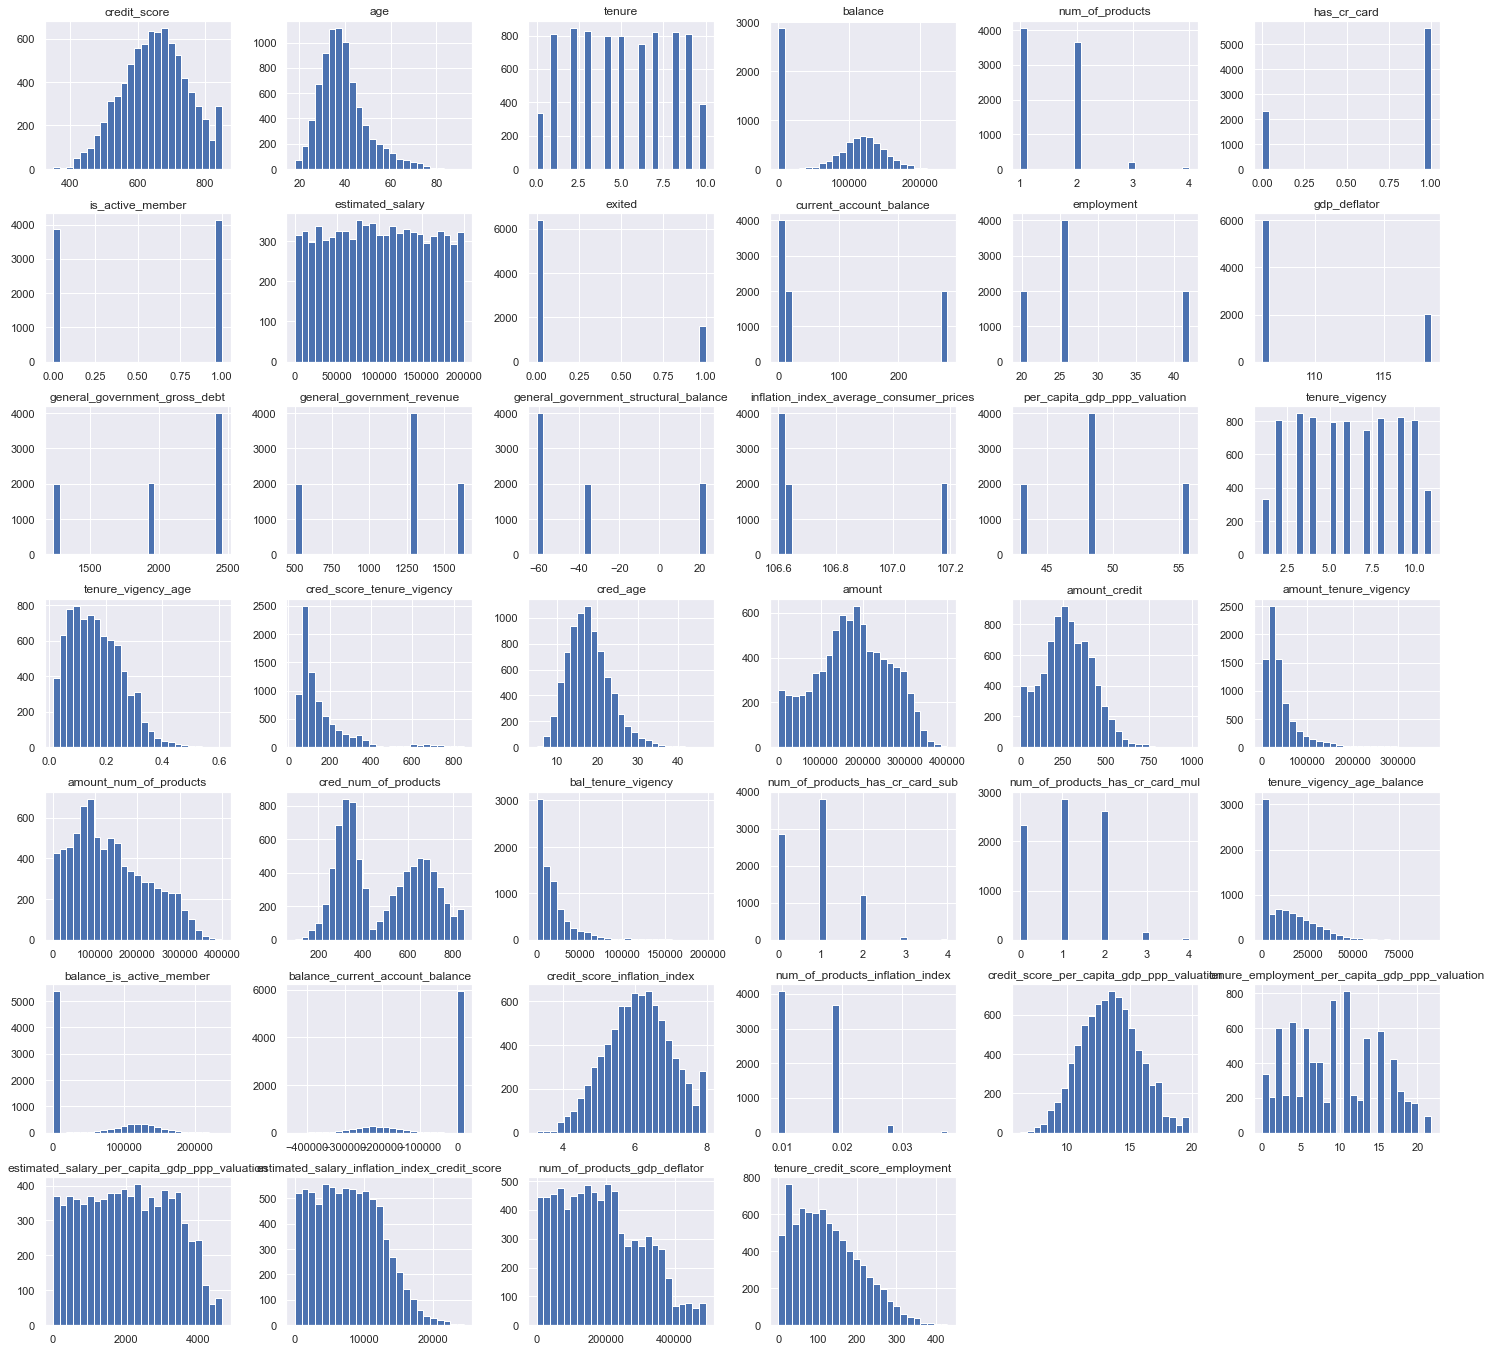

In [34]:
num_attributes.hist(bins=25, figsize=(25,24));

### 4.2.2 Categorical Attributes

In [35]:
#Categorical Attributes
cat_attributes = df04.select_dtypes(include=['object'])

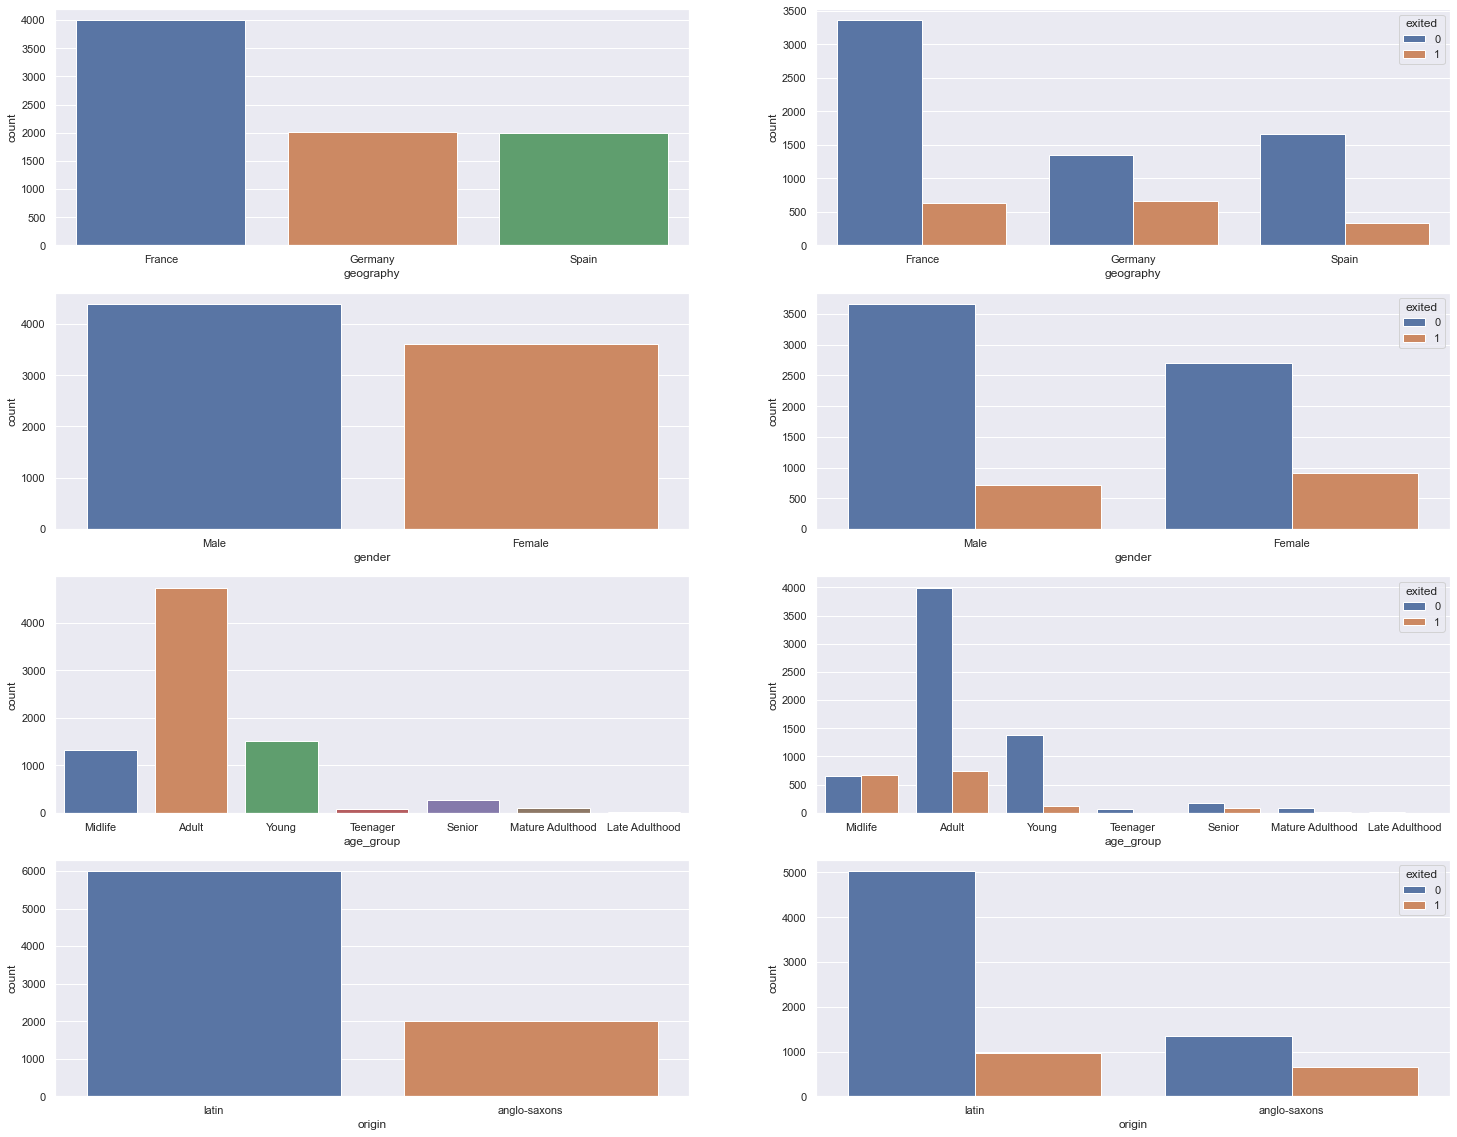

In [36]:
count = 1
rows= len(cat_attributes.columns)
plt.figure(figsize=(25,5*rows))
for i in cat_attributes:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df04)
    count += 1
plt.show()

## 4.3 Bivariate Analysis

### 4.3.1 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

### H01 - Men usually have more churn
---
> - Conclusion: **FALSE** 
>> **WOMEN** have more churn

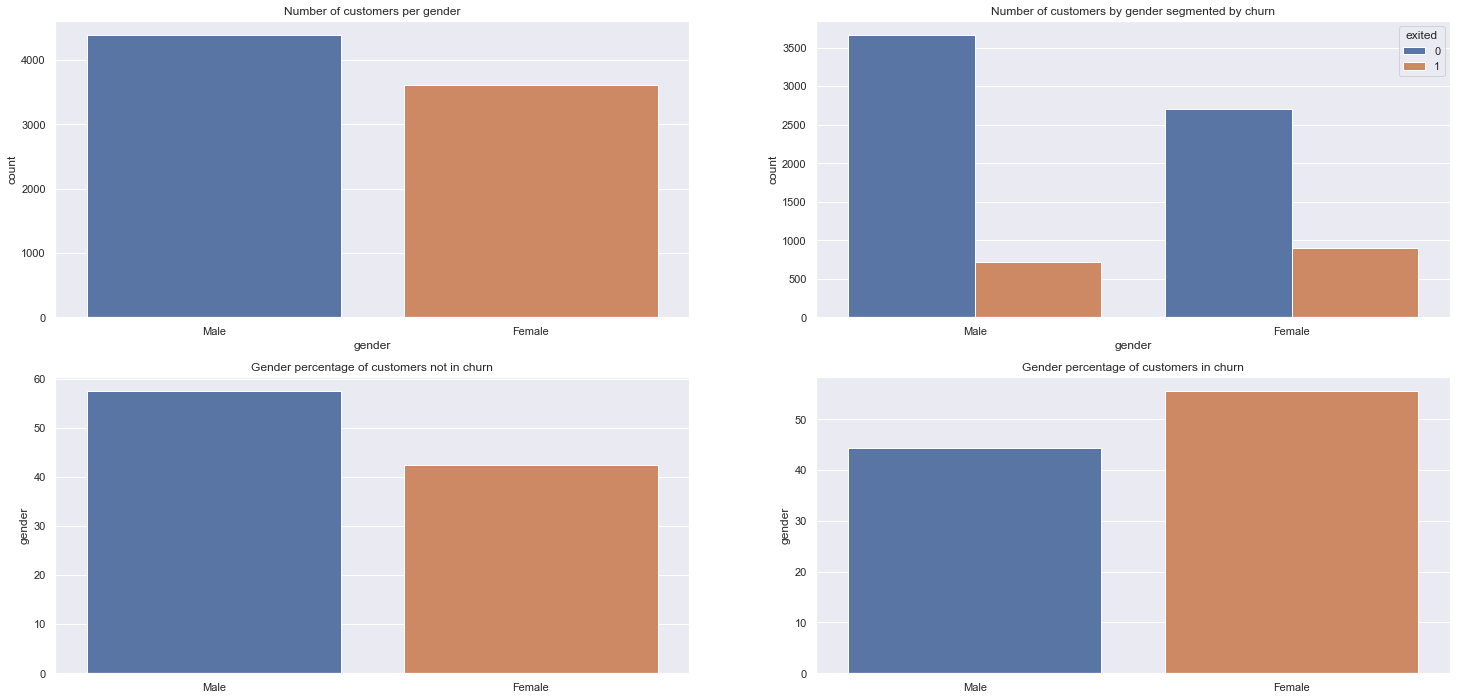

In [37]:
plt.subplot(2,2,1)
sns.countplot(x='gender', order=['Male', 'Female'], data=df04).set_title('Number of customers per gender');

plt.subplot(2,2,2)
sns.countplot(x='gender', hue='exited', order=['Male', 'Female'], data=df04).set_title('Number of customers by gender segmented by churn');

plt.subplot(2,2,3)
gender_percentage_not_churn = df04[df04['exited'] == 0]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_not_churn.index, y=gender_percentage_not_churn, order=['Male', 'Female']).set_title('Gender percentage of customers not in churn');

plt.subplot(2,2,4)
gender_percentage_churn = df04[df04['exited'] == 1]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_churn.index, y=gender_percentage_churn, order=['Male', 'Female']).set_title('Gender percentage of customers in churn');

### H02 - Younger clients are less loyal and more likely to leave a bank
---
> - Conclusion: **FALSE** 
>> Younger clients are **MORE** loyal and more likely to leave a bank

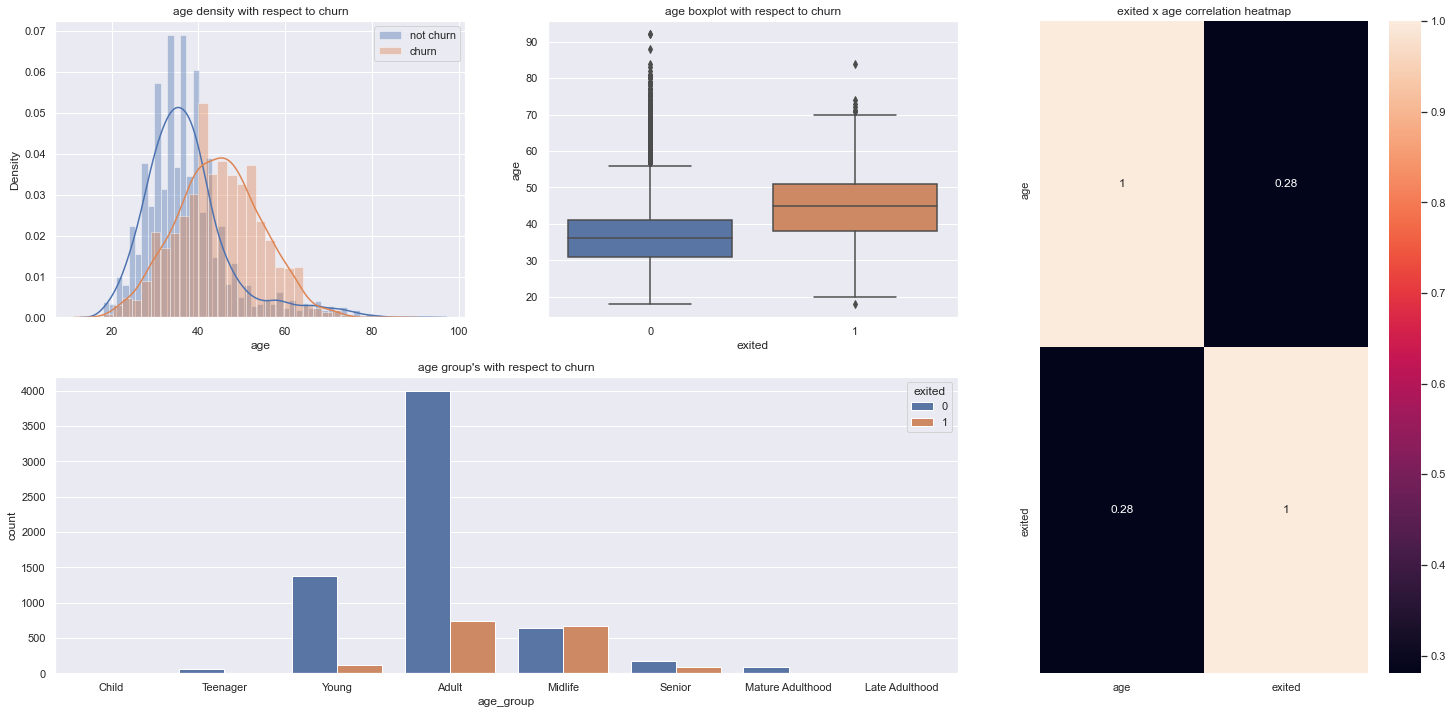

In [38]:
aux02 = df04[['age', 'age_group', 'exited']]

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
#sns.histplot(x='age', bins=25, hue='exited', data=aux01);
sns.distplot(aux02[aux02['exited'] == 0]['age'], label='not churn');
sns.distplot(aux02[aux02['exited'] == 1]['age'], label='churn');
plt.title("age density with respect to churn");
plt.legend();

plt.subplot(grid[0,1])
sns.boxplot(x='exited', y='age', data=aux02).set_title("age boxplot with respect to churn");

plt.subplot(grid[1,:2])
sns.countplot(x='age_group', hue='exited', order=['Child', 'Teenager', 'Young',
                                                  'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood'], data=aux02);
plt.title("age group's with respect to churn");

plt.subplot(grid[:,2])
sns.heatmap(aux02.corr(method='pearson'),annot=True).set_title("exited x age correlation heatmap");

### H03 - Churn should occur for customers with high salary
---
> - Conclusion: **TRUE** 
>> Churn occur for clients with high salary

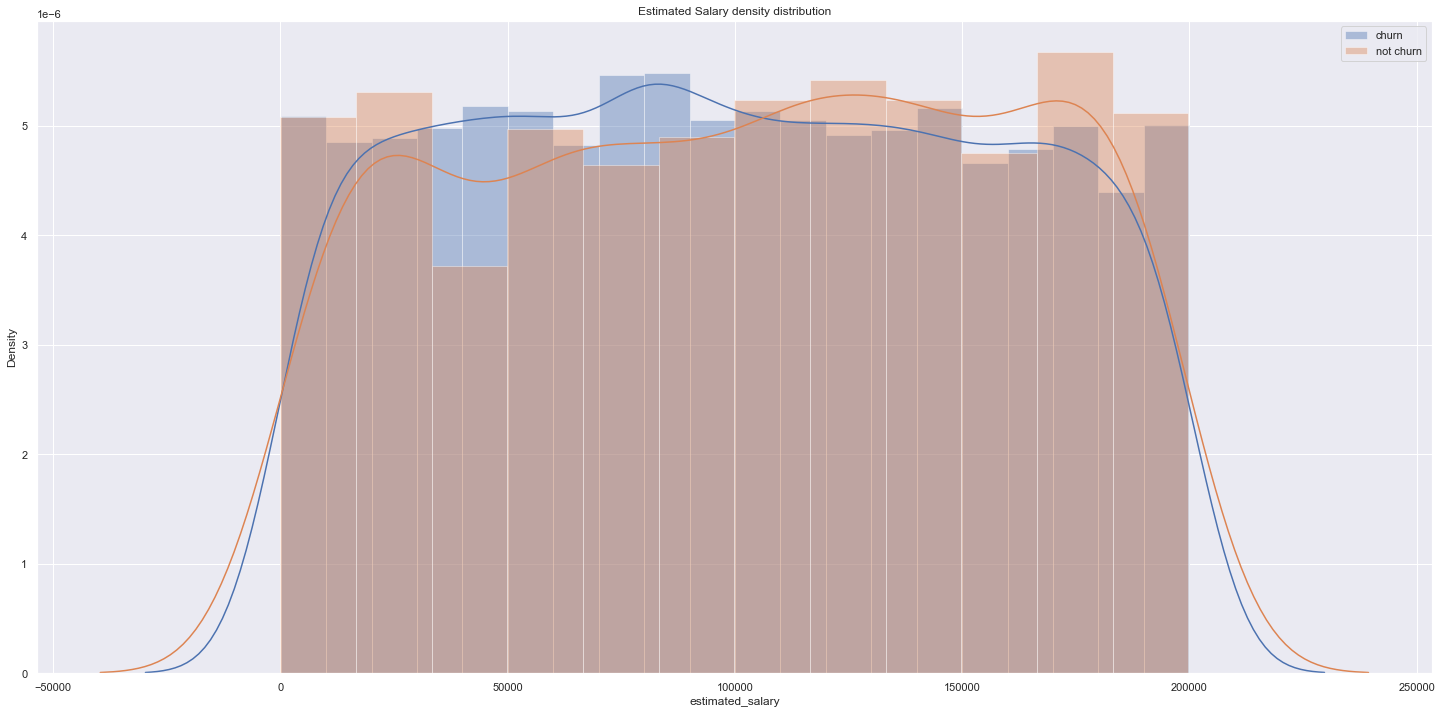

In [39]:
sns.distplot(df04[df04['exited'] == 0]['estimated_salary'], kde=True, label='churn')
sns.distplot(df04[df04['exited'] == 1]['estimated_salary'], kde=True, label='not churn')
plt.title('Estimated Salary density distribution');
plt.legend();

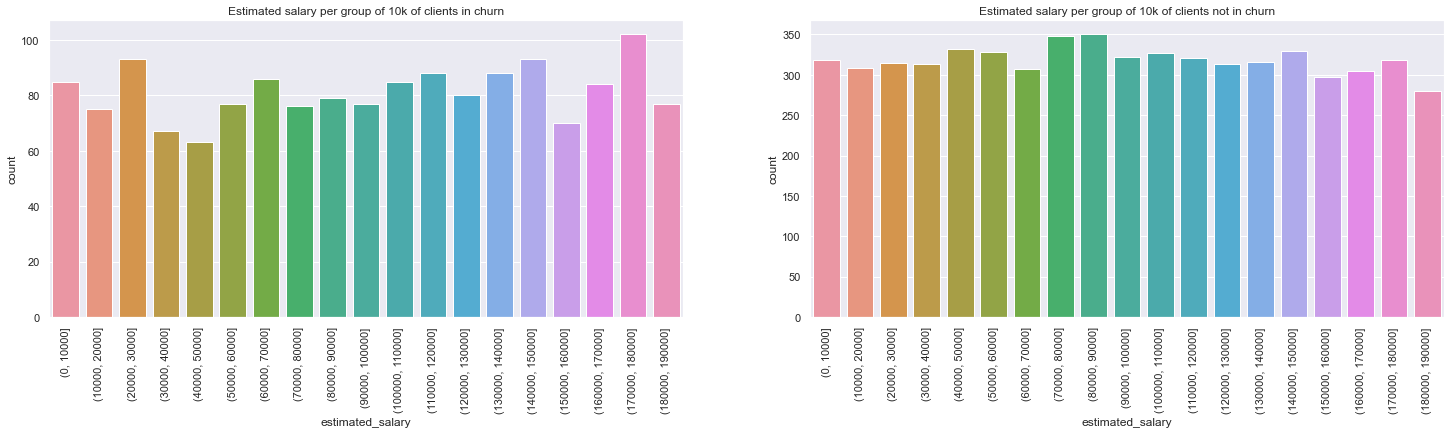

In [40]:
bins = list(np.arange(0, 200000, 10000))

aux03_churn = pd.cut(df04[df04['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04[df04['exited'] == 0]['estimated_salary'], bins=bins)

plt.subplot(2,2,1)
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=90);

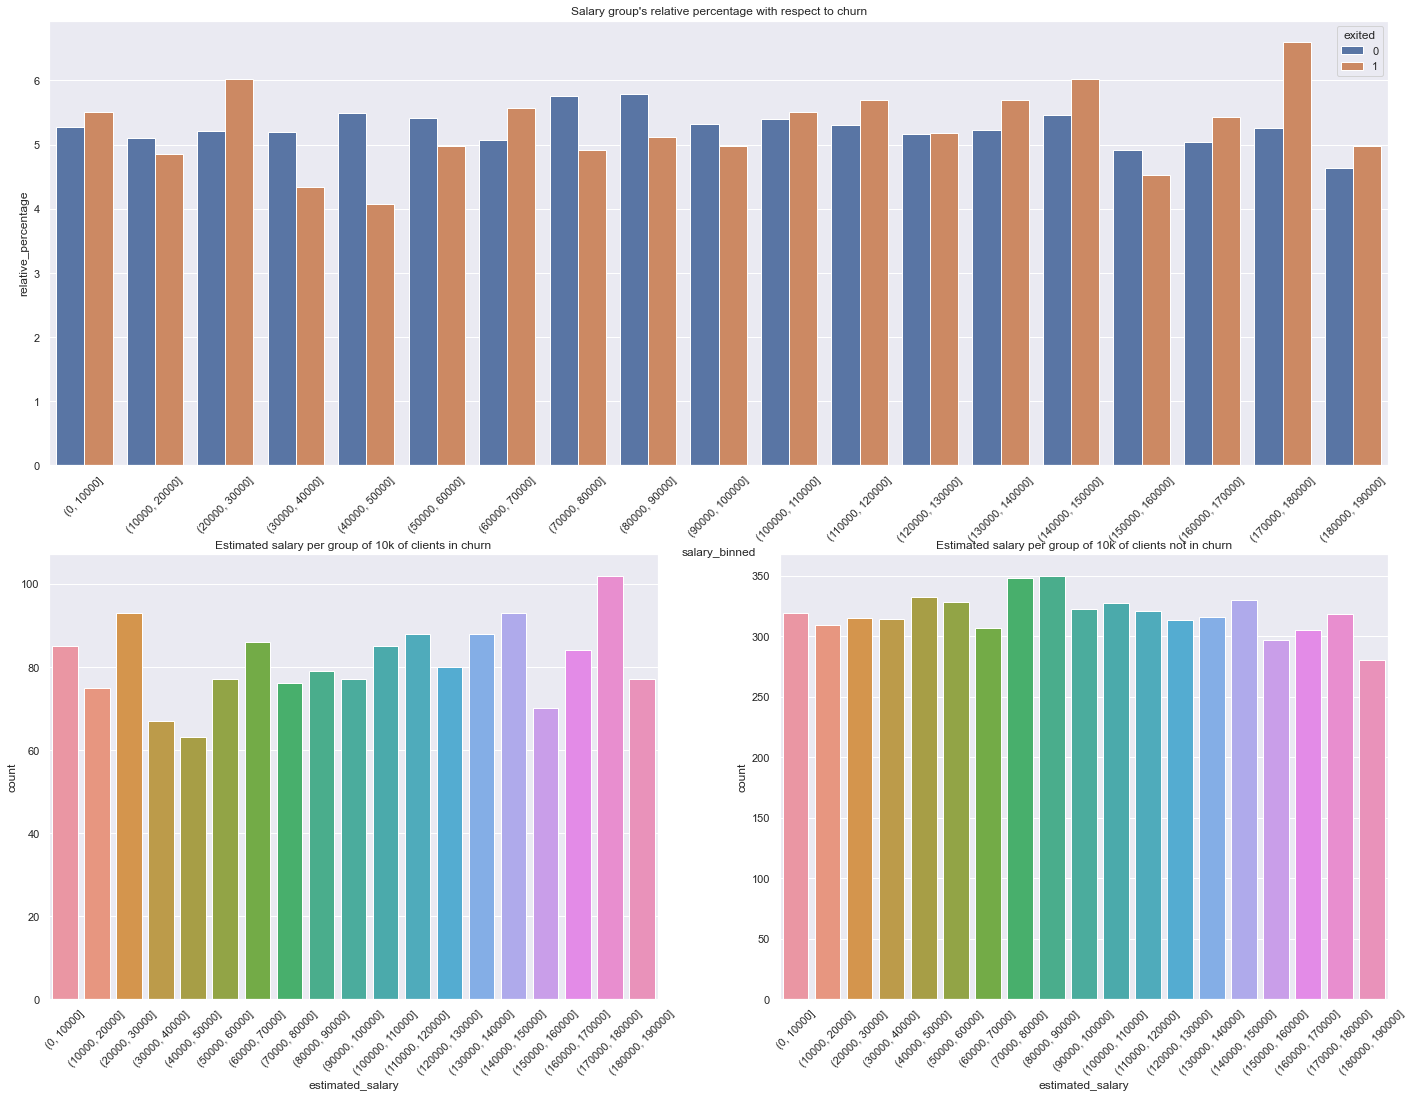

In [41]:
# bins
bins = list(np.arange(0, 200000, 10000))

# create new dataframe
aux03 = df04[['estimated_salary', 'exited']]
aux03['salary_binned'] = pd.cut(aux03['estimated_salary'], bins=bins)

# salary_binned, exited and number of clients
aux03 = aux03[['salary_binned', 'estimated_salary', 'exited']].groupby(['salary_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux03.columns = ['salary_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux03_churn = aux03[aux03['exited'] == 1]['customers'].sum()
aux03_not_churn = aux03[aux03['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux03['relative_percentage'] = aux03.\
apply(lambda row: ((row['customers'] / aux03_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux03_not_churn)*100), axis=1)


# Grid for ploting
plt.figure(figsize(24,18))
grid = GridSpec(2, 2)

# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[0,:])
sns.barplot(x='salary_binned', y='relative_percentage', hue='exited', data=aux03).set_title("Salary group's relative percentage with respect to churn");
plt.xticks(rotation=45);

# New auxiliary analyses for plot
aux03_churn = pd.cut(df04[df04['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04[df04['exited'] == 0]['estimated_salary'], bins=bins)

# plot Estimated salary per group of 10k of clients in churn
plt.subplot(grid[1,0])
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=45);

# plot Estimated salary per group of 10k of clients not in churn
plt.subplot(grid[1,1])
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=45);

### H04 - Churn should occur for customers with high balance
---
> - Conclusion: **TRUE** 
>> Churn occur for customers with high balance

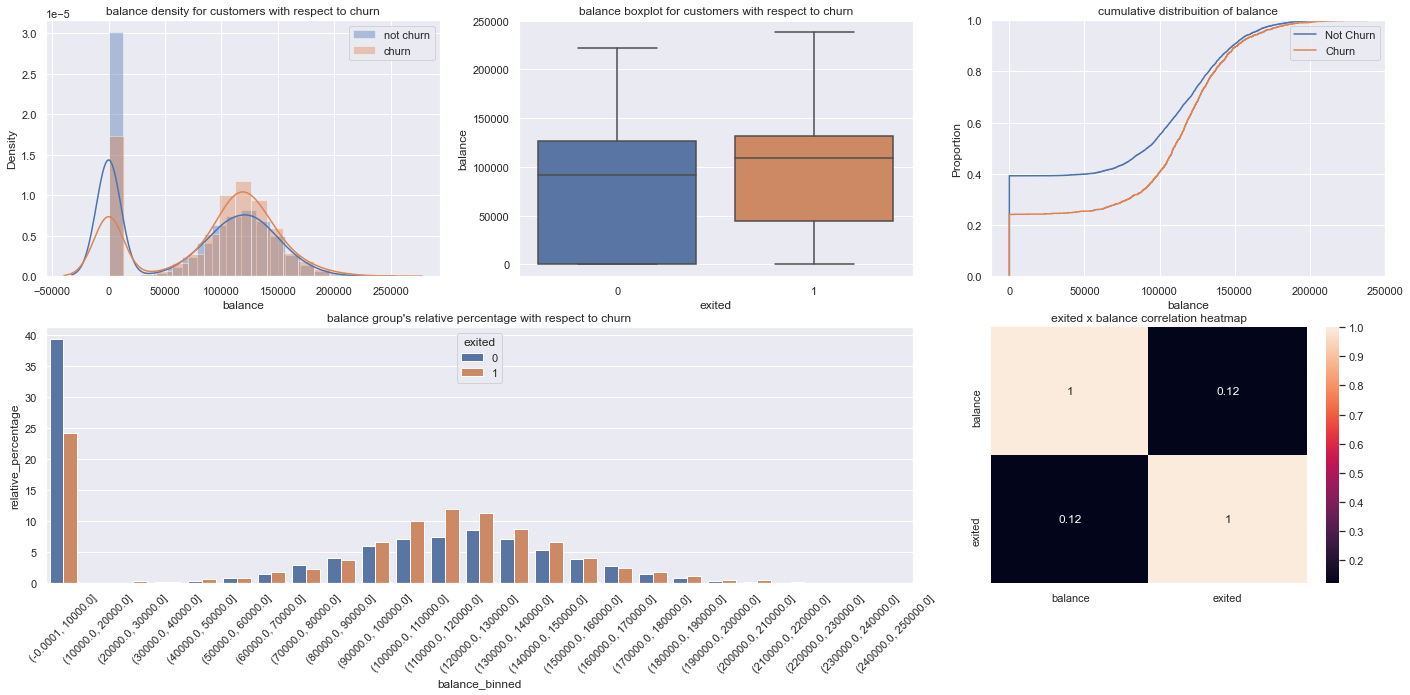

In [98]:
# bins
bins = list(np.arange(-0.0001, 250000, 10000))

# create new dataframe
aux04 = df04[['balance', 'exited']]

# Grid for ploting
plt.figure(figsize(24,16))
grid = GridSpec(3, 3)

# balance density
plt.subplot(grid[0,0])
sns.distplot(aux04[aux04['exited'] == 0]['balance'], label='not churn');
sns.distplot(aux04[aux04['exited'] == 1]['balance'], label='churn');
plt.title("balance density for customers with respect to churn");
plt.legend();

# balance boxplot
plt.subplot(grid[0,1])
sns.boxplot(x="exited", y="balance", data=aux04).set_title("balance boxplot for customers with respect to churn");

# ecdf balance
plt.subplot(grid[0,2])
sns.ecdfplot(data=aux04[aux04['exited'] == 0], x="balance", label='Not Churn');
sns.ecdfplot(data=aux04[aux04['exited'] == 1], x="balance", label='Churn');
plt.title("cumulative distribuition of balance")
plt.legend()


# exited x balance correlation heatmap
plt.subplot(grid[1,2])
sns.heatmap(aux04.corr(method='pearson'),annot=True);
plt.title("exited x balance correlation heatmap");

# create binned column
aux04['balance_binned'] = pd.cut(aux04['balance'], bins=bins)

# salary_binned, exited and number of clients
aux04 = aux04[['balance_binned', 'balance', 'exited']].groupby(['balance_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux04.columns = ['balance_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux04_churn = aux04[aux04['exited'] == 1]['customers'].sum()
aux04_not_churn = aux04[aux04['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux04['relative_percentage'] = aux04.\
apply(lambda row: ((row['customers'] / aux04_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux04_not_churn)*100), axis=1)


# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[1,:2])
sns.barplot(x='balance_binned', y='relative_percentage', hue='exited', data=aux04).set_title("balance group's relative percentage with respect to churn");
plt.xticks(rotation=45);

### H05 - Countries of Latin origin have higher number of churn
---
> - Conclusion: **FALSE** 
>> Countries of **Anglo-Saxons** origin have higher number of churn

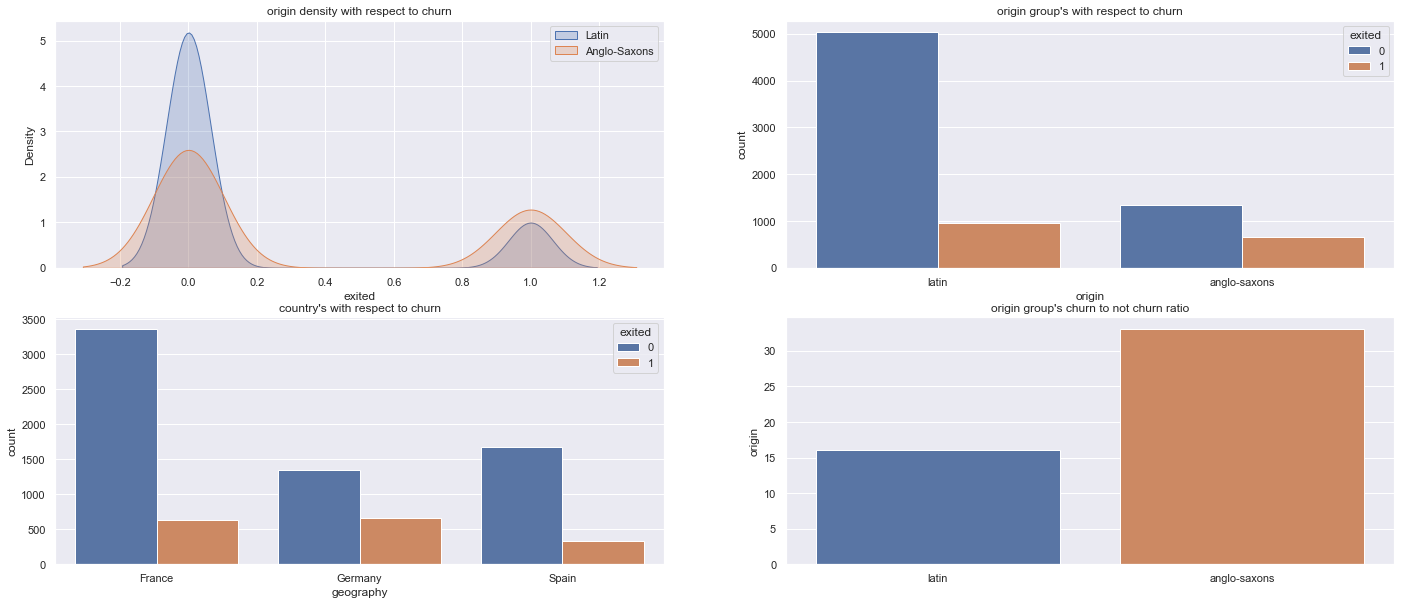

In [96]:
aux05 = df04[['origin', 'exited', 'geography']]

# figure size
plt.figure(figsize(24,10))

# origin density
plt.subplot(2,2,1)
sns.kdeplot(aux05[aux05['origin'] == 'latin']['exited'], label='Latin', shade=True);
sns.kdeplot(aux05[aux05['origin'] == 'anglo-saxons']['exited'], label='Anglo-Saxons', shade=True);
plt.title("origin density with respect to churn");
plt.legend();

# origin group's
plt.subplot(2,2,2)
sns.countplot(x='origin', hue='exited', data=aux05).set_title("origin group's with respect to churn");

# country's plot
plt.subplot(2,2,3)
sns.countplot(x='geography', hue='exited', data=aux05).set_title("country's with respect to churn");

# origin group's churn to not churn ratio
plt.subplot(2,2,4)
aux05_ratio_churn = aux05[aux05['exited']==1]['origin'].value_counts()\
/ (aux05[aux05['exited']==0]['origin'].value_counts() + aux05[aux05['exited']==1]['origin'].value_counts())*100
sns.barplot(x=aux05_ratio_churn.index, y=aux05_ratio_churn).\
set_title("origin group's churn to not churn ratio");

### H06 - Active members should have less churn
---
> - Conclusion: **TRUE**
>> Active members have less churn

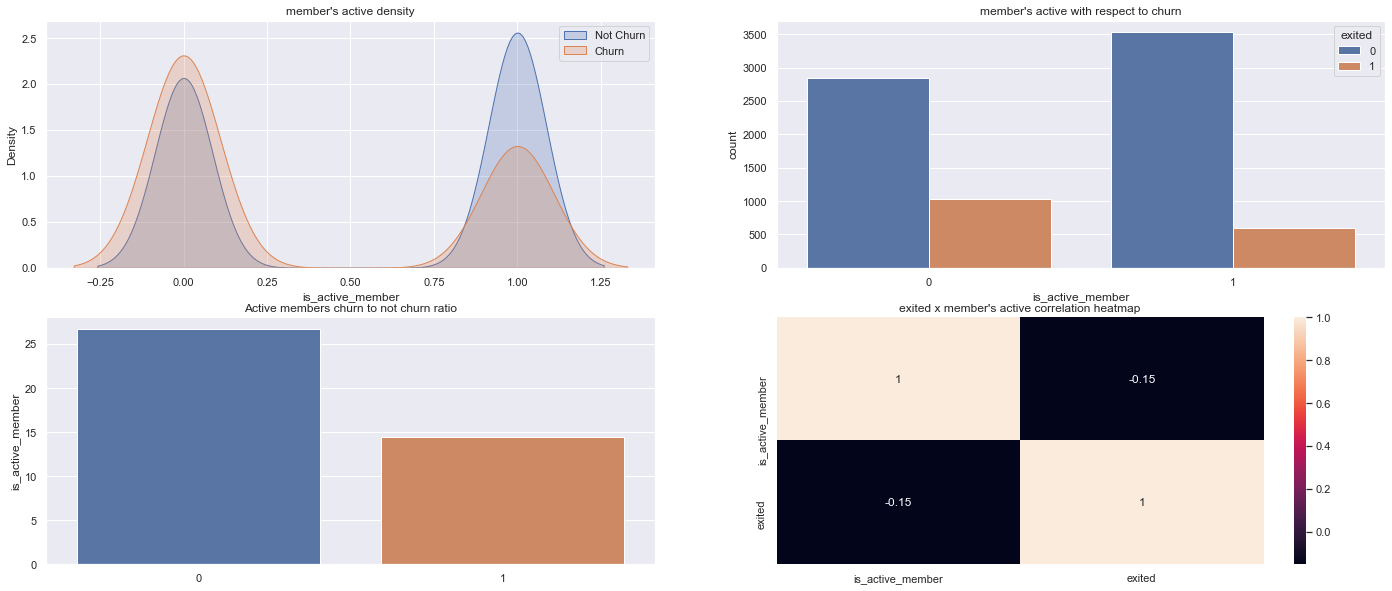

In [95]:
aux06 = df04[['is_active_member', 'exited']]

# figure size
plt.figure(figsize(24,10))

# member's active density
plt.subplot(2,2,1)
sns.kdeplot(aux06[aux06['exited'] == 0]['is_active_member'], label='Not Churn', shade=True);
sns.kdeplot(aux06[aux06['exited'] == 1]['is_active_member'], label='Churn', shade=True);
plt.title("member's active density")
plt.legend()

# member's active with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='is_active_member', hue='exited', data=aux06).set_title("member's active with respect to churn");

# Active members churn to not churn ratio
plt.subplot(2,2,3)
aux06_ratio_churn = aux06[aux06['exited']==1]['is_active_member'].value_counts()\
                                            / (aux06[aux06['exited']==0]['is_active_member'].value_counts() + aux06[aux06['exited']==1]['is_active_member'].value_counts())*100
sns.barplot(x=aux06_ratio_churn.index, y=aux06_ratio_churn).\
set_title("Active members churn to not churn ratio");

# exited x member's active correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux06.corr(method='pearson'),annot=True);
plt.title("exited x member's active correlation heatmap");

### H07 - Churn should occur for customers with low tenure
---
> - Conclusion: **FALSE** 
>> Churn occur for customers with high tenur

<Figure size 1728x576 with 0 Axes>

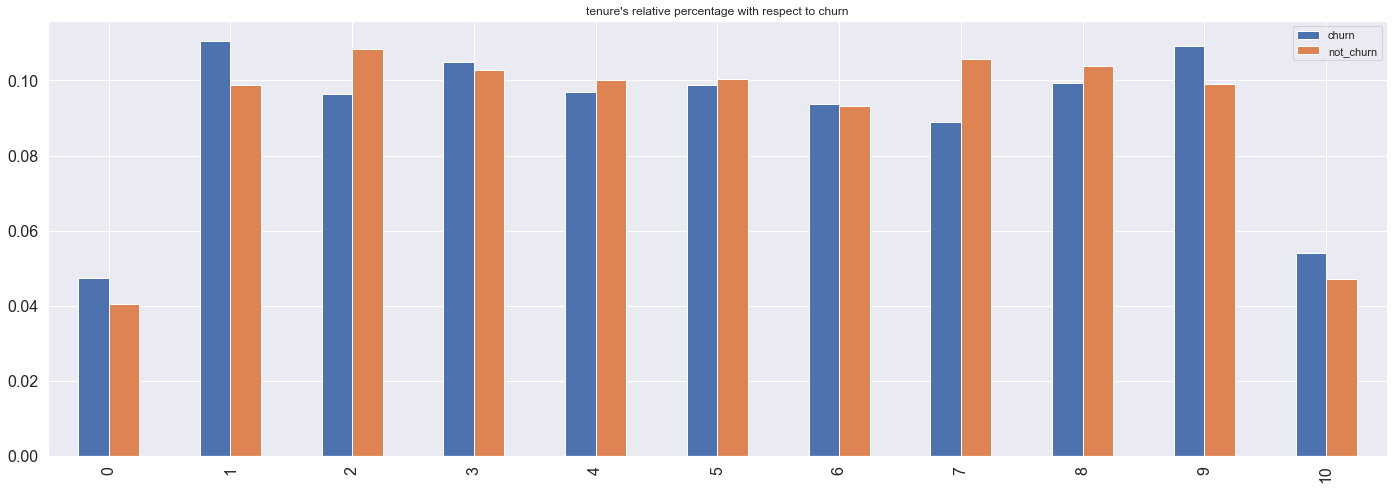

In [59]:
tenure_percentage = num_attributes['tenure'].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn = pd.DataFrame()
tenure_percentage_hue_churn['churn'] = num_attributes['tenure'][num_attributes['exited'] == 1].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn['not_churn'] = num_attributes['tenure'][num_attributes['exited'] != 1].value_counts(normalize=True).sort_index()

# figure size
plt.figure(figsize(24,8));

tenure_percentage_hue_churn.plot(kind='bar', stacked=False, fontsize=16);
plt.title("tenure's relative percentage with respect to churn");

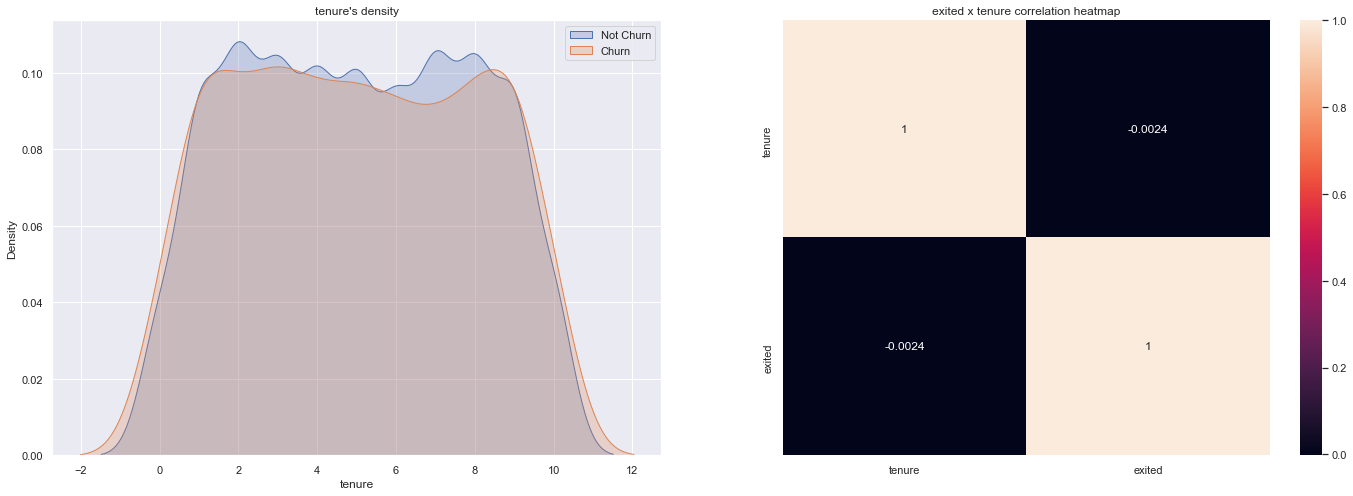

In [60]:
aux07 = df04[['tenure', 'exited']]

plt.subplot(1,2,1)
sns.kdeplot(aux07[aux07['exited'] == 0]['tenure'], label='Not Churn', shade=True);
sns.kdeplot(aux07[aux07['exited'] == 1]['tenure'], label='Churn', shade=True);
plt.title("tenure's density");
plt.legend();

plt.subplot(1,2,2)
sns.heatmap(aux07.corr(method='pearson'),annot=True);
plt.title("exited x tenure correlation heatmap");

### H08 - The more products the customer has, the less likely it is to go into churn
---
> - Conclusion: **FALSE** 
>> Customers with more than two products have a better chance of getting into churn

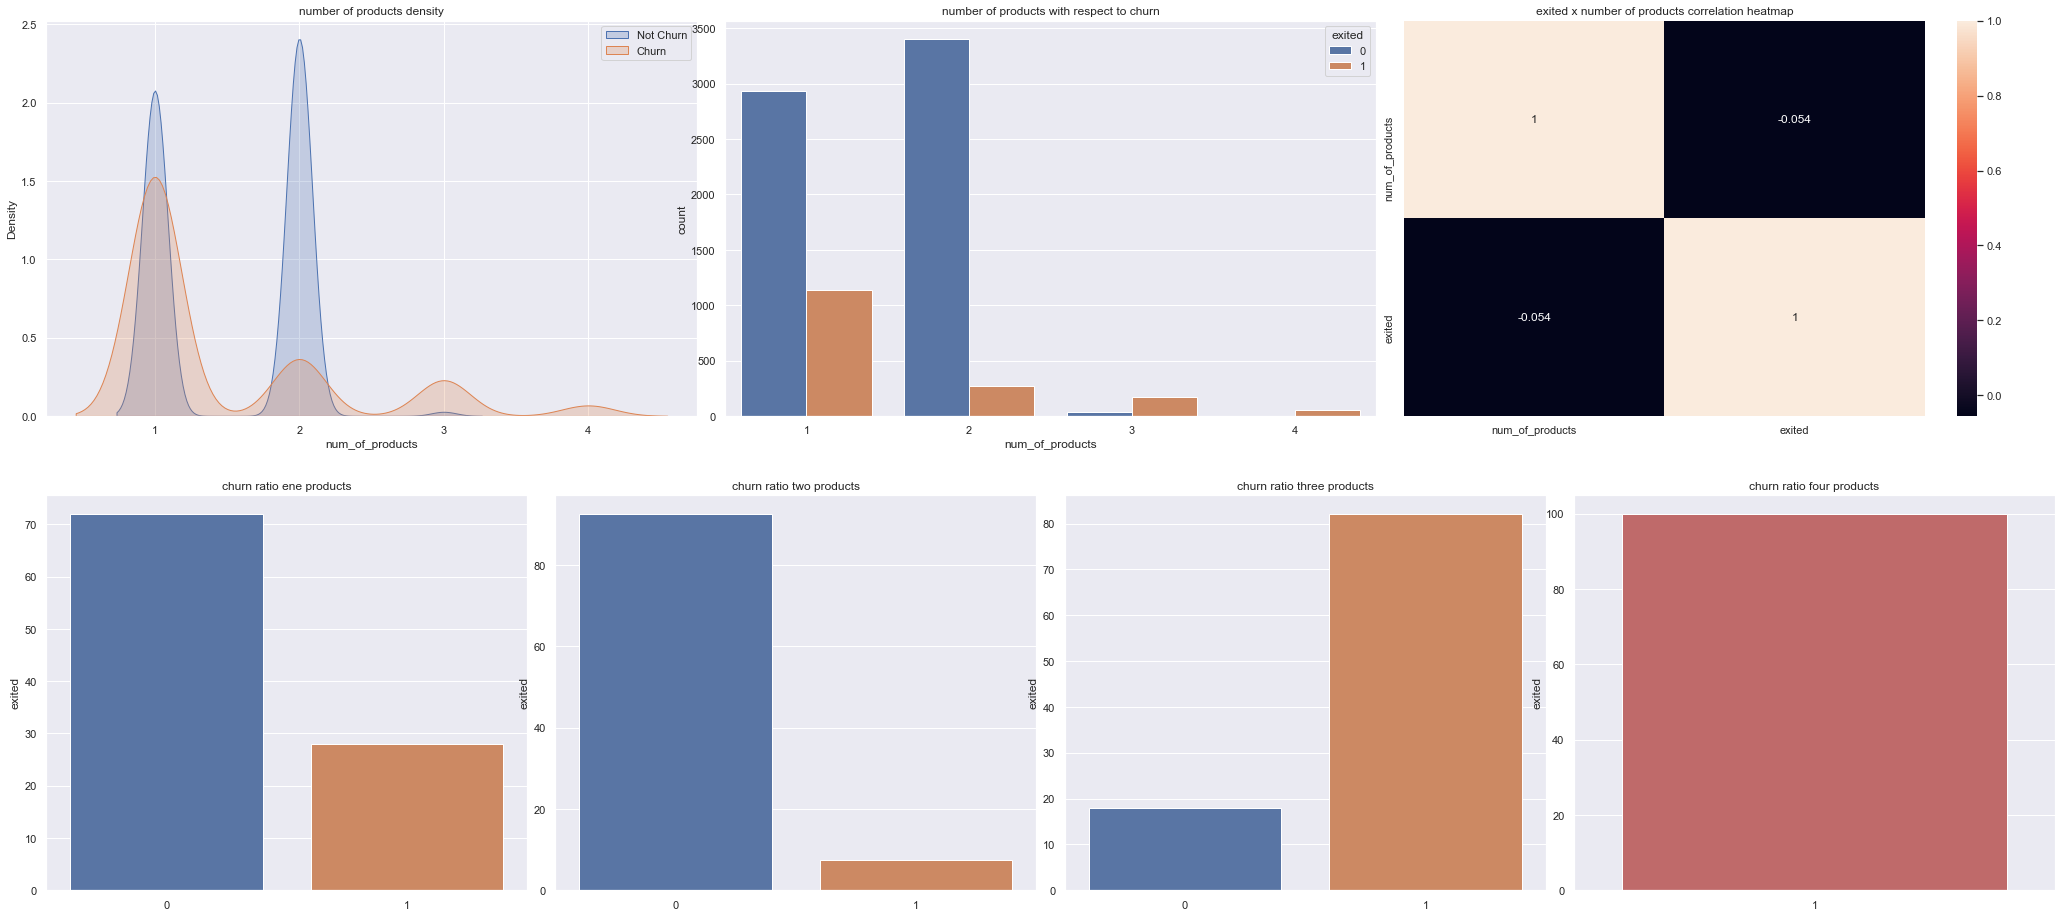

In [90]:
aux08 = df04[['num_of_products', 'exited']]

# Grid for ploting
plt.figure(figsize(36,16))
grid = GridSpec(2, 12)

# number of products density
plt.subplot(grid[0,:4])
sns.kdeplot(aux08[aux08['exited'] == 0]['num_of_products'], label='Not Churn', shade=True);
sns.kdeplot(aux08[aux08['exited'] == 1]['num_of_products'], label='Churn', shade=True);
plt.title("number of products density");
plt.legend();

# number of products with respect to churn
plt.subplot(grid[0,4:8])
sns.countplot(x='num_of_products', hue='exited', data=aux08).set_title("number of products with respect to churn");

# exited x number of products correlation heatmap
plt.subplot(grid[0,8:12])
sns.heatmap(aux08.corr(method='pearson'),annot=True);
plt.title("exited x number of products correlation heatmap");

# churn ratio {num_of_products} products
dict_num_of_products = {
                            1: 'ene',
                            2: 'two',
                            3: 'three',
                            4: 'four'
                        }

for i in dict_num_of_products.keys():
    churn_prod = aux08[aux08['num_of_products']==i]['exited'].value_counts(normalize=True)*100
    if churn_prod.iloc[0] != 100:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));
    else:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, color='indianred',  y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));

### H09 - Customers with Credit Cards tend to stay at the bank
---
> - Conclusion: **TRUE** 
>> Customers who have a credit card have lower churn rate

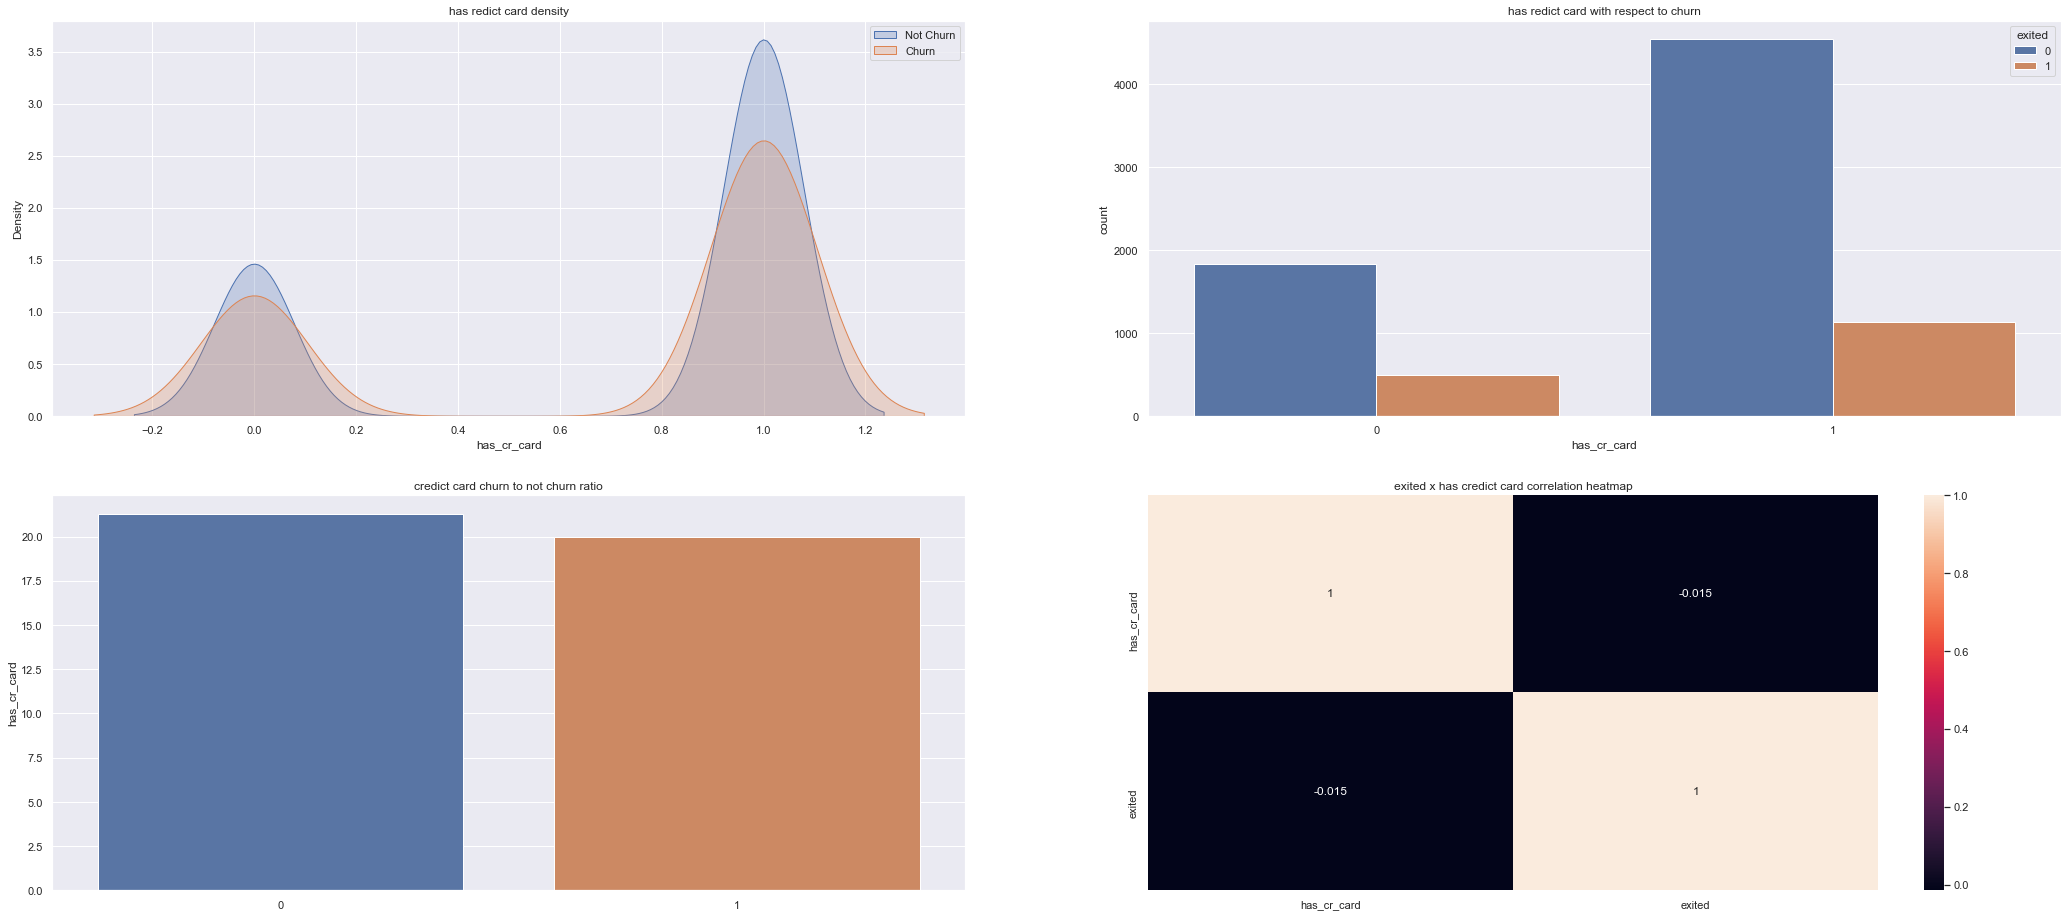

In [94]:
aux09 = df04[['has_cr_card', 'exited']]

# has redict card density
plt.subplot(2,2,1)
sns.kdeplot(aux09[aux09['exited'] == 0]['has_cr_card'], label='Not Churn', shade=True);
sns.kdeplot(aux09[aux09['exited'] == 1]['has_cr_card'], label='Churn', shade=True);
plt.title("has redict card density")
plt.legend()

# has redict card with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='has_cr_card', hue='exited', data=aux09).set_title("has redict card with respect to churn");

# credict card churn to not churn ratio
plt.subplot(2,2,3)
aux09_ratio_churn = aux09[aux09['exited']==1]['has_cr_card'].value_counts()\
                                                / (aux09[aux09['exited']==0]['has_cr_card'].value_counts() + aux09[aux09['exited']==1]['has_cr_card'].value_counts())*100
sns.barplot(x=aux09_ratio_churn.index, y=aux09_ratio_churn).\
set_title("credict card churn to not churn ratio");

# exited x has credict card correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux09.corr(method='pearson'),annot=True);
plt.title("exited x has credict card correlation heatmap");

## 4.4 Multivariate Analysis

### 4.4.1 Numerical and Boolean Attributes

In [99]:
# Numerical Attributes and Boolean
num_attributes = df04.select_dtypes(include=['int64', 'float64'])

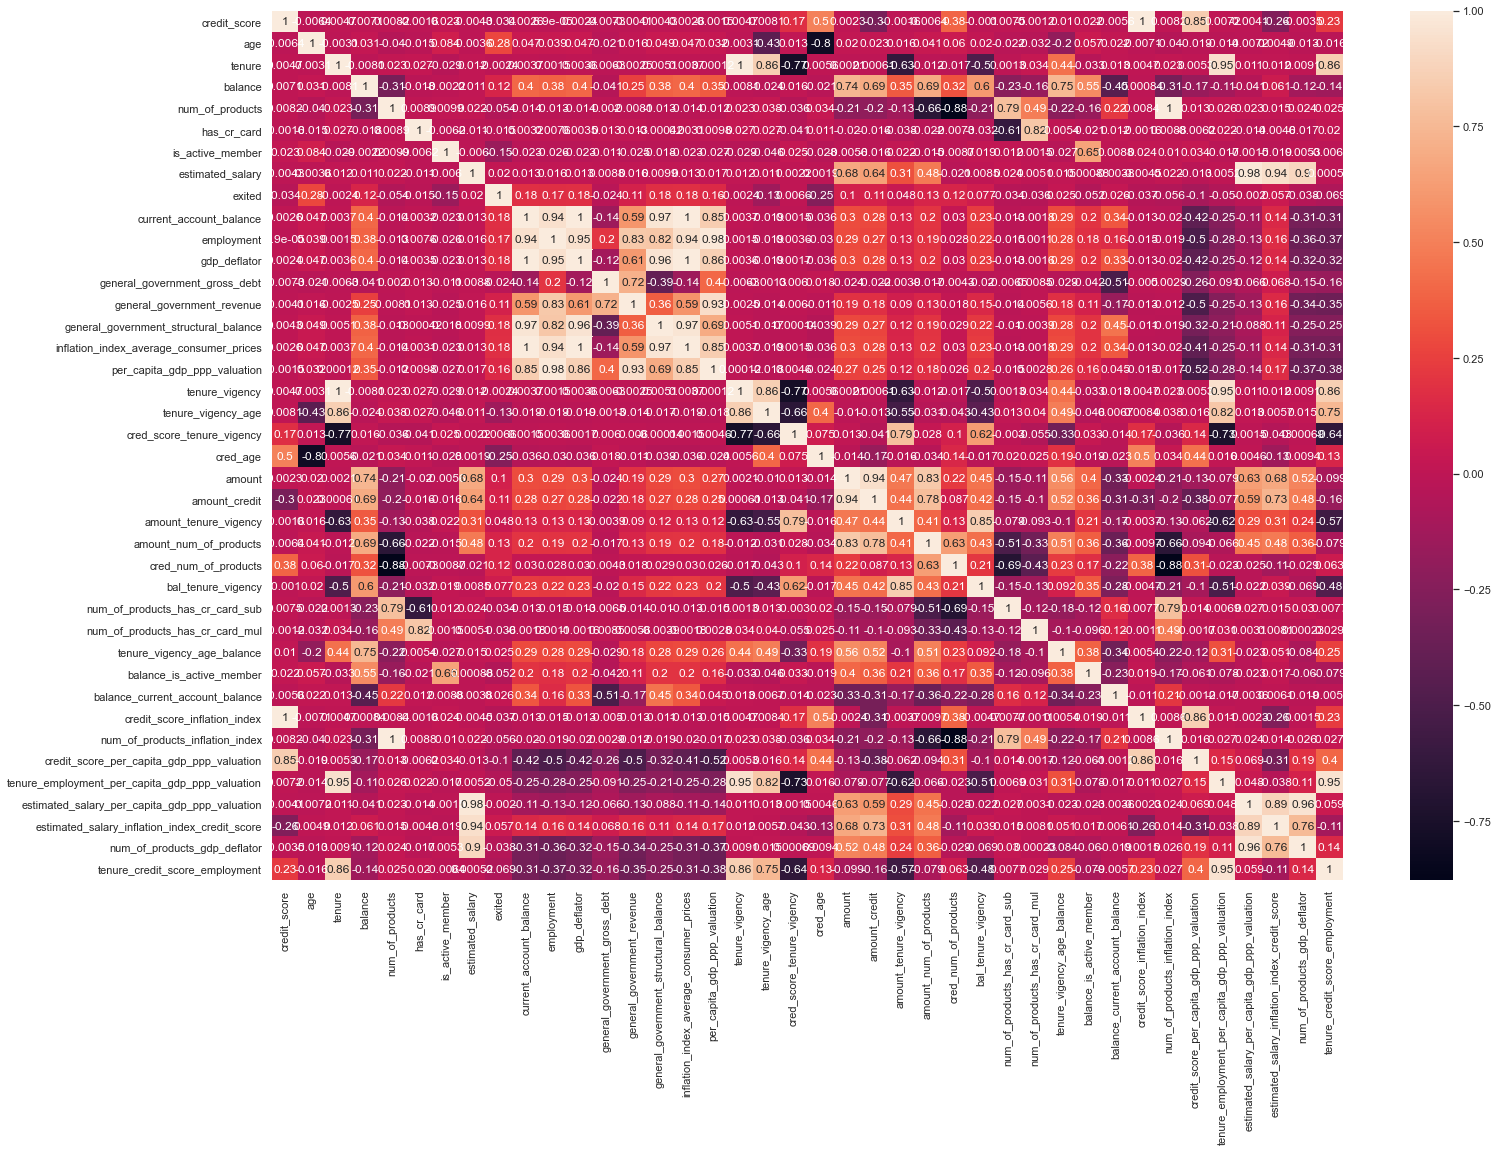

In [104]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize(24,16));
sns.heatmap(correlation, annot=True);

### 4.4.2 Categorical Attributes

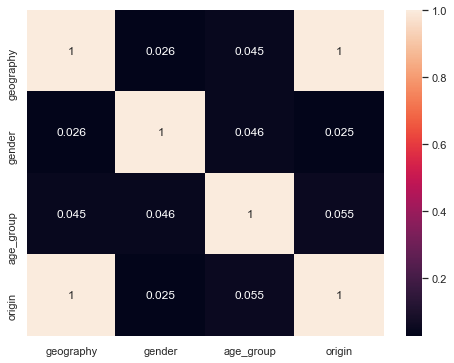

In [111]:
a1 = cramerV(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramerV(cat_attributes['geography'], cat_attributes['gender'])
a3 = cramerV(cat_attributes['geography'], cat_attributes['age_group'])
a4 = cramerV(cat_attributes['geography'], cat_attributes['origin'])

a5 = cramerV(cat_attributes['gender'], cat_attributes['geography'])
a6 = cramerV(cat_attributes['gender'], cat_attributes['gender'])
a7 = cramerV(cat_attributes['gender'], cat_attributes['age_group'])
a8 = cramerV(cat_attributes['gender'], cat_attributes['origin'])

a9 = cramerV(cat_attributes['age_group'], cat_attributes['geography'])
a10 = cramerV(cat_attributes['age_group'], cat_attributes['gender'])
a11 = cramerV(cat_attributes['age_group'], cat_attributes['age_group'])
a12 = cramerV(cat_attributes['age_group'], cat_attributes['origin'])

a13 = cramerV(cat_attributes['origin'], cat_attributes['geography'])
a14 = cramerV(cat_attributes['origin'], cat_attributes['gender'])
a15 = cramerV(cat_attributes['origin'], cat_attributes['age_group'])
a16 = cramerV(cat_attributes['origin'], cat_attributes['origin'])

#Final Dataset
dict_cramerV = {
                'geography':[a1, a2, a3, a4],
                'gender':[a5, a6, a7, a8],
                'age_group':[a9, a10, a11, a12],
                'origin':[a13, a14, a15, a16]
                }

d = pd.DataFrame(dict_cramerV)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True)
plt.show()

# 5.0 DATA PREPARATION

In [114]:
df05 = df04.copy()

## 5.1 Transformation

### 5.1.1 ~~Normalization~~

In [116]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib as jb

### 5.1.2 Rescaling

#### 5.1.2.1 RobustScaler

In [117]:
rs = RobustScaler()

# balance
df05['balance'] = rs.fit_transform(df05[['balance']].values)
jb.dump(rs,'parameter/balance_scaler.pkl.z')

# tenure_vigency_age_balance
df05['tenure_vigency_age_balance'] = rs.fit_transform(df05[['tenure_vigency_age_balance']].values)
jb.dump(rs,'parameter/tenure_vigency_age_balance.pkl.z')

# balance_is_active_member
df05['balance_is_active_member'] = rs.fit_transform(df05[['balance_is_active_member']].values)
jb.dump(rs,'parameter/balance_is_active_member.pkl.z')

# balance_current_account_balance
df05['balance_current_account_balance'] = rs.fit_transform(df05[['balance_current_account_balance']].values)
jb.dump(rs,'parameter/balance_current_account_balance.pkl.z')

['parameter/balance_current_account_balance.pkl.z']

#### 5.1.2.2 MinMaxScaler

In [118]:
mms = MinMaxScaler()

# credit_score
df05['credit_score'] = mms.fit_transform(df05[['credit_score']].values)
jb.dump(rs,'parameter/credit_score.pkl.z')

# age
df05['age'] = mms.fit_transform(df05[['age']].values)
jb.dump(rs,'parameter/age.pkl.z')

# tenure
df05['tenure'] = mms.fit_transform(df05[['tenure']].values)
jb.dump(rs,'parameter/tenure.pkl.z')

# num_of_products
df05['num_of_products'] = mms.fit_transform(df05[['num_of_products']].values)
jb.dump(rs,'parameter/num_of_products.pkl.z')

# estimated_salary
df05['estimated_salary'] = mms.fit_transform(df05[['estimated_salary']].values)
jb.dump(rs,'parameter/estimated_salary.pkl.z')

# current_account_balance
df05['current_account_balance'] = mms.fit_transform(df05[['current_account_balance']].values)
jb.dump(rs,'parameter/current_account_balance.pkl.z')

# employment
df05['employment'] = mms.fit_transform(df05[['employment']].values)
jb.dump(rs,'parameter/employment.pkl.z')

# gdp_deflator
df05['gdp_deflator'] = mms.fit_transform(df05[['gdp_deflator']].values)
jb.dump(rs,'parameter/gdp_deflator.pkl.z')

# general_government_gross_debt
df05['general_government_gross_debt'] = mms.fit_transform(df05[['general_government_gross_debt']].values)
jb.dump(rs,'parameter/general_government_gross_debt.pkl.z')

# general_government_structural_balance
df05['general_government_structural_balance'] = mms.fit_transform(df05[['general_government_structural_balance']].values)
jb.dump(rs,'parameter/general_government_structural_balance.pkl.z')

# inflation_index_average_consumer_prices
df05['inflation_index_average_consumer_prices'] = mms.fit_transform(df05[['inflation_index_average_consumer_prices']].values)
jb.dump(rs,'parameter/inflation_index_average_consumer_prices.pkl.z')

# per_capita_gdp_ppp_valuation
df05['per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/per_capita_gdp_ppp_valuation.pkl.z')

# tenure_vigency_age
df05['tenure_vigency_age'] = mms.fit_transform(df05[['tenure_vigency_age']].values)
jb.dump(rs,'parameter/tenure_vigency_age.pkl.z')

# cred_score_tenure_vigency
df05['cred_score_tenure_vigency'] = mms.fit_transform(df05[['cred_score_tenure_vigency']].values)
jb.dump(rs,'parameter/cred_score_tenure_vigency.pkl.z')

# amount
df05['amount'] = mms.fit_transform(df05[['amount']].values)
jb.dump(rs,'parameter/amount.pkl.z')

# amount_credit
df05['amount_credit'] = mms.fit_transform(df05[['amount_credit']].values)
jb.dump(rs,'parameter/amount_credit.pkl.z')

# amount_num_of_products
df05['amount_num_of_products'] = mms.fit_transform(df05[['amount_num_of_products']].values)
jb.dump(rs,'parameter/amount_num_of_products.pkl.z')

# cred_num_of_products
df05['cred_num_of_products'] = mms.fit_transform(df05[['cred_num_of_products']].values)
jb.dump(rs,'parameter/cred_num_of_products.pkl.z')

# num_of_products_has_cr_card_sub
df05['num_of_products_has_cr_card_sub'] = mms.fit_transform(df05[['num_of_products_has_cr_card_sub']].values)
jb.dump(rs,'parameter/num_of_products_has_cr_card_sub.pkl.z')

# num_of_products_has_cr_card_mul
df05['num_of_products_has_cr_card_mul'] = mms.fit_transform(df05[['num_of_products_has_cr_card_mul']].values)
jb.dump(rs,'parameter/num_of_products_has_cr_card_mul.pkl.z')

# credit_score_inflation_index
df05['credit_score_inflation_index'] = mms.fit_transform(df05[['credit_score_inflation_index']].values)
jb.dump(rs,'parameter/credit_score_inflation_index.pkl.z')

# tenure_employment_per_capita_gdp_ppp_valuation
df05['tenure_employment_per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['tenure_employment_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/tenure_employment_per_capita_gdp_ppp_valuation.pkl.z')

# estimated_salary_per_capita_gdp_ppp_valuation
df05['estimated_salary_per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['estimated_salary_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/estimated_salary_per_capita_gdp_ppp_valuation.pkl.z')

# num_of_products_gdp_deflator
df05['num_of_products_gdp_deflator'] = mms.fit_transform(df05[['num_of_products_gdp_deflator']].values)
jb.dump(rs,'parameter/num_of_products_gdp_deflator.pkl.z')

# tenure_credit_score_employment
df05['tenure_credit_score_employment'] = mms.fit_transform(df05[['tenure_credit_score_employment']].values)
jb.dump(rs,'parameter/tenure_credit_score_employment.pkl.z')

['parameter/tenure_credit_score_employment.pkl.z']

#### 5.1.2.1 StandardScaler

In [119]:
ss = StandardScaler()

# cred_age
df05['cred_age'] = ss.fit_transform(df05[['cred_age']].values)
jb.dump(rs,'parameter/cred_age.pkl.z')

# bal_tenure_vigency
df05['bal_tenure_vigency'] = ss.fit_transform(df05[['bal_tenure_vigency']].values)
jb.dump(rs,'parameter/bal_tenure_vigency.pkl.z')

# credit_score_per_capita_gdp_ppp_valuation
df05['credit_score_per_capita_gdp_ppp_valuation'] = ss.fit_transform(df05[['credit_score_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/credit_score_per_capita_gdp_ppp_valuation.pkl.z')

['parameter/credit_score_per_capita_gdp_ppp_valuation.pkl.z']

### 5.1.3 Encoding

In [120]:
#AgeGroup -> One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['age_group'], columns=['age_group'], drop_first=True)

#Geography -> One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['geography'], columns=['geography'], drop_first=True)

# Gender
df05['gender'] = np.where(df05['gender'] == 'Female', 1, 0)

# origin
df05['origin'] = np.where(df05['origin'] == 'Latin', 1, 0)

# 6.0 FEATURE SELECTION

In [121]:
df06 = df05.copy()

## 6.1 Split dataframe into training and test dataset

In [125]:
from boruta                  import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
X = df06.drop(columns=['exited'], axis=1)
y = df06['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and Validation dataset for Boruta
X_train_n = X_train.to_numpy()
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
boruta.fit(X_train_n, y_train_n)

BorutaPy(estimator=RandomForestClassifier(n_estimators=46, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1B2FA607C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1B2FA607C40)

## 6.2 Boruta as Feature Selector

In [126]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['age',
 'balance',
 'num_of_products',
 'cred_age',
 'amount_num_of_products',
 'cred_num_of_products',
 'num_of_products_has_cr_card_mul',
 'balance_current_account_balance',
 'num_of_products_inflation_index',
 'age_group_Midlife']

In [127]:
cols_selected = [
        'age',
        'balance',
        'num_of_products',
        'cred_age',
        'amount_num_of_products',
        'cred_num_of_products',
        'num_of_products_has_cr_card_mul',
        'balance_current_account_balance',
        'num_of_products_inflation_index',
        'age_group_Midlife']

# 7.0 MACHINE LEARNING MODELLING

In [45]:
#https://gitlab.com/datascience-community/pa003_churn_predict/-/blob/pa003_bruno_santos/pa003_churn_prediction_V01.ipynb